Read and preprocess data
-----------

Here we read the ground truth and the predicted scale values

In [1]:
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (12, 9)
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [2]:
def read_preprocess_data(result_file):
    df = pd.read_csv(result_file, index_col=0)
    df['error'] = df.apply(lambda x: x.gt_scale - x.pred_scale, axis=1)
    df['abs_error'] = df.apply(lambda x: np.abs(x.error), axis=1)
    return df

In [3]:
df = read_preprocess_data('./results_flow_v2.1_sequential.csv')

A plot of the ground truth and the predicted scale values.  The predictions reflect the trends in data and are noisy.

<IPython.core.display.Javascript object>


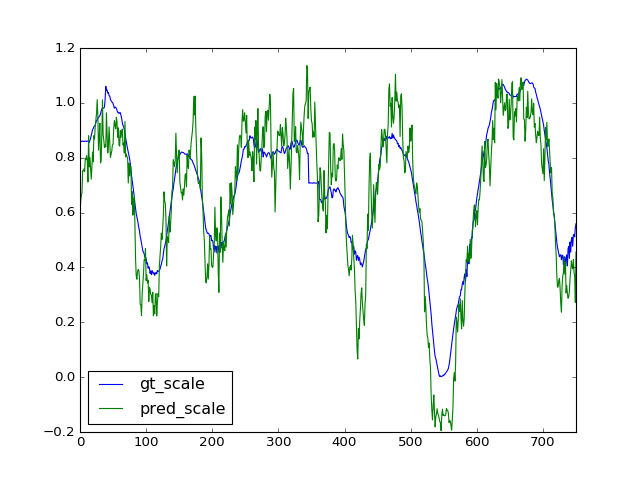

In [53]:
df.loc[:750, ['gt_scale', 'pred_scale']].plot()

The following graphs present the original data (speed) and its first two derivatives.

[ 1.52928891  1.52372259  1.51417158  1.51329533  1.53607109  1.48403467
  1.50043197  1.49506016  1.49336815  1.48891692]


<IPython.core.display.Javascript object>


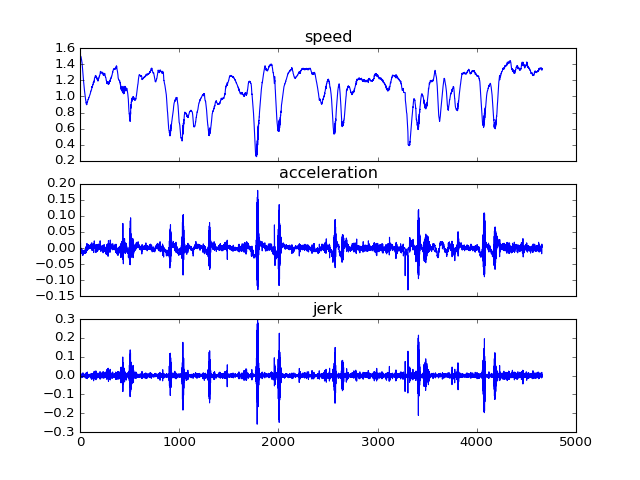

In [59]:
df1 = pd.read_csv('/home/akreimer/prj/monocular_odometry/workspace/list_files/image_0/02.txt', delim_whitespace=True, header=None, names=['image1', 'image2', 'gt_scale'])
gt_scale = df1.gt_scale.values
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(gt_scale, label='velocity')
axarr[0].set_title('speed')
axarr[1].plot(np.diff(gt_scale, n=1))
axarr[1].set_title('acceleration')
axarr[2].plot(np.diff(gt_scale, n=2))
axarr[2].set_title('jerk')
plt.legend()

In [6]:
def FirstOrderKF(x0, R, Q, dt):
    """ Create first order Kalman filter. Specify R and Q as floats."""
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = x0
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    print kf.R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

In [7]:
def filter_data(kf, zs):
    xs, ps = [], []
    for z in zs:
        kf.predict()
        kf.update(z)

        xs.append(kf.x)
        ps.append(kf.P.diagonal()) # just save variances
    
    return np.asarray(xs), np.asarray(ps)

[[ 0.1]]
kf preiction mean error: 0.110443165454
raw rediction mean error: 0.0880240730598


<IPython.core.display.Javascript object>


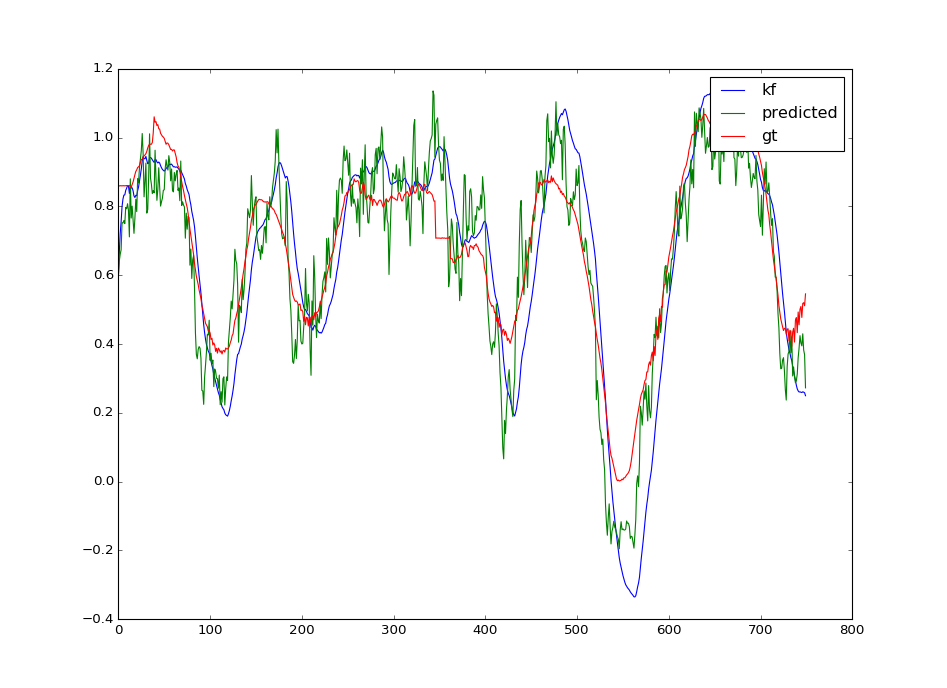

In [48]:
dt = .1
x0 = np.array([1., 1.])
kf = FirstOrderKF(x0, R=.1, Q=.01, dt=dt)

zs = df.pred_scale.values
xs, cov = filter_data(kf, zs)

err = np.mean(np.abs(df.gt_scale.values - xs[:, 0]))
print 'kf preiction mean error:', err
print 'raw rediction mean error:', np.mean(np.abs(df.error))

first, last = 0, 750
plt.figure()
plt.plot(xs[first:last,0], label='kf')
plt.plot(df.pred_scale.values[first:last], label='predicted')
plt.plot(df.gt_scale.values[first:last], label='gt')
plt.legend()

In [9]:
def read_poses(pose_file_path):
    poses = []
    with open(pose_file_path, 'r') as f:
        for line in f:
            # print line
            pose = np.array([float(val) for val in line.split()]).reshape(3, 4)
            # print pose
            poses.append(pose)
    return poses

def get_path(poses):
    x0 = np.array([0,0,0,1])
    path = []
    for pose in poses:
        path.append(np.dot(pose, x0))
    return np.array(path)

def plot_path(path, color='green'):
    if isinstance(color, basestring):
        for i, segment in enumerate(path[:-1]):
            plt.plot(path[i:i+2, 0], path[i:i+2, 2], alpha=0.7, color=color)
    else:
        for i, segment in enumerate(path[:-1]):
            plt.plot(path[i:i+2, 0], path[i:i+2, 2], alpha=0.7, color=cm.plasma(colors[i]))

In [10]:
import os
from matplotlib import cm

data_dir = './dataset/poses'
pose_file_path = os.path.join(data_dir, '00.txt') 
poses = read_poses(pose_file_path)
path = get_path(poses)

err = np.abs(df.gt_scale.values - df.pred_scale.values)
color = np.abs(err) / np.max(np.abs(err))

In [40]:
def rescale_poses(poses, scales):
    scaled_poses = [poses[0]]
    for i in range(1, len(poses)-1):
        aux = np.array([0, 0, 0, 1]).reshape((1, -1))
        pose1 = np.concatenate((poses[i-1], aux), axis=0)
        pose2 = np.concatenate((poses[i], aux), axis=0)
        
        delta = np.dot(np.linalg.inv(pose1), pose2)
        t = delta[:3, 3]
        # print 'original t, scale', t, np.linalg.norm(t)
        t /= np.linalg.norm(t)
        t *= scales[i]
        # print 'rescaled t, scale', t, np.linalg.norm(t), scales[i]
        delta[:3, 3] = t
        pose2 = np.dot(scaled_poses[-1], delta)
        scaled_poses.append(pose2[:3,:])
    return scaled_poses

<IPython.core.display.Javascript object>


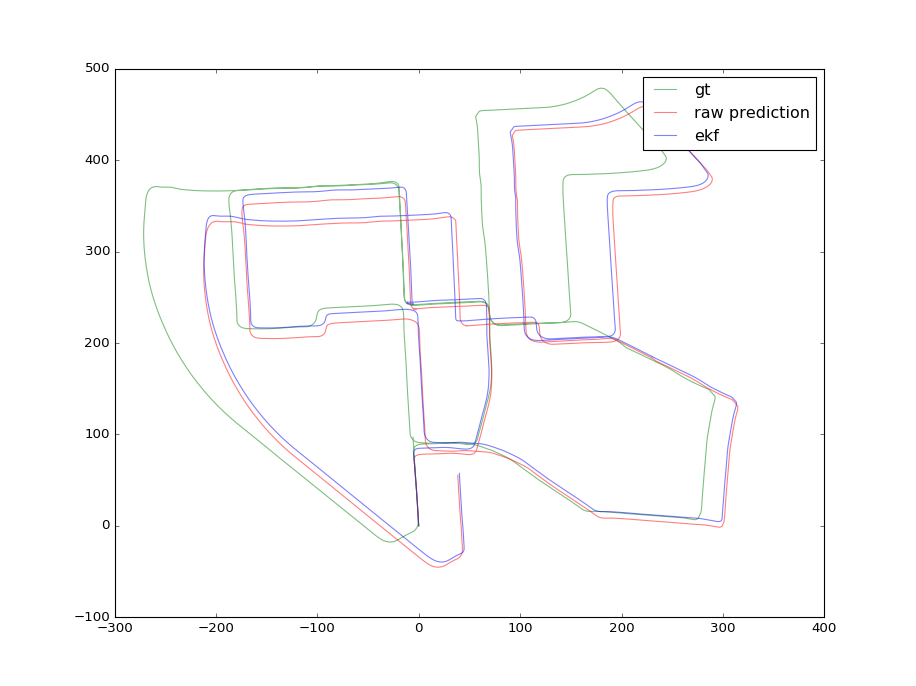

In [44]:
scaled_poses = rescale_poses(poses, df.pred_scale.values)
scaled_path = get_path(scaled_poses)

scaled_ekf = rescale_poses(poses, xs[:,0])
ekf_path = get_path(scaled_ekf)

fig = plt.figure()
plt.plot(path[:,0], path[:, 2], color='green', alpha=.5, label='gt')
plt.plot(scaled_path[:,0], scaled_path[:, 2], color='red', alpha=.5, label='raw prediction')
plt.plot(ekf_path[:,0], ekf_path[:, 2], color='blue', alpha=.5, label='ekf')
plt.legend()

<IPython.core.display.Javascript object>


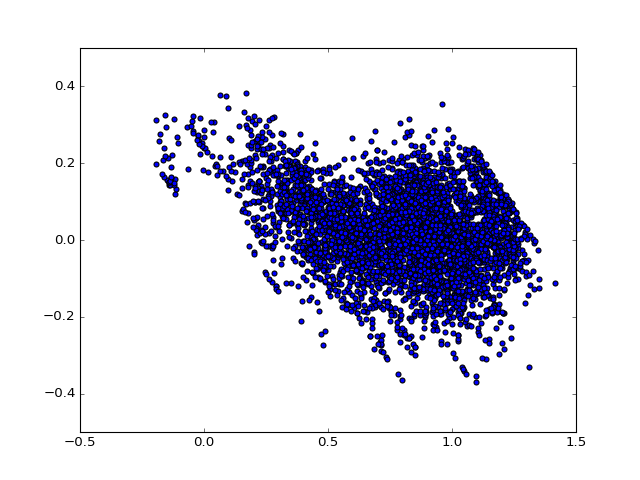

In [47]:
plt.figure()
plt.scatter(df.pred_scale, df.gt_scale-df.pred_scale)

In [64]:
with open('flownet_loss_train.txt', 'r') as fd:
    data = [float(f) for f in fd.read().split()]

<IPython.core.display.Javascript object>


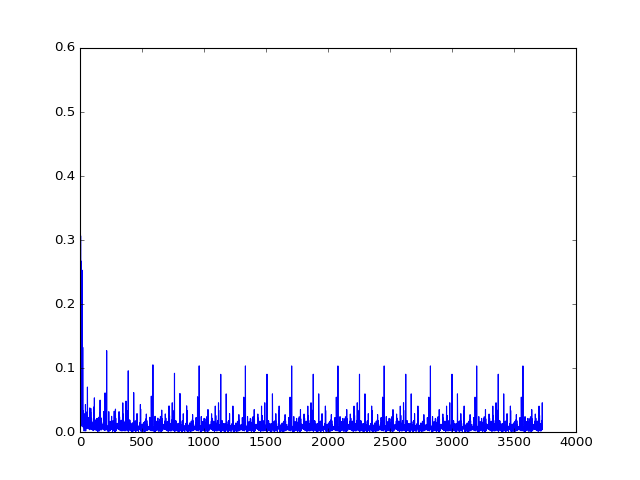

In [66]:
plt.figure()
plt.plot(data)